# Training Convergence Plots for Learning Punctuation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect

from conv_plots_funcs import train_conv_plots

#import empirical cdf
# import sys
# sys.path.append(os.path.abspath('../../src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio
# sys.path.append(os.path.abspath('..'))

from check_ecdf import get_empirical_cdf

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
Using device: cuda


In [2]:
valA = "ident"
valC = "_ident_C"
state_dim = 5
ckpt_step = 8
experiment = "250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = False


compute_more_ckpts = False

/home/sultand/TFs_do_KF_ICL/outputs/train_conv/training_dist_comparison_val_ident_state_dim_5_val_sys_25_1737749139.7811897.png
ckpt_steps: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 1

(array([0.47643214, 0.7719369 , 1.1867851 ], dtype=float32),
 [200,
  400,
  600,
  800,
  1000,
  1200,
  1400,
  1600,
  1800,
  2000,
  2200,
  2400,
  2600,
  2800,
  3000,
  3200,
  3400,
  3600,
  3800,
  4000,
  4200,
  4400,
  4600,
  4800,
  5000,
  5200,
  5400,
  5600,
  5800,
  6000,
  6200,
  6400,
  6600,
  6800,
  7000,
  7200,
  7400,
  7600,
  7800,
  8000,
  8200,
  8400,
  8600,
  8800,
  9000,
  9200,
  9400,
  9600,
  9800,
  10000,
  10200,
  10400,
  10600,
  10800,
  11000,
  11200,
  11400,
  11600,
  11800,
  12000,
  12200,
  12400,
  12600,
  12800,
  13000,
  13200,
  13400,
  13600,
  13800,
  14000,
  14200,
  14400,
  14600,
  14800,
  15000,
  15200,
  15400,
  15600,
  15800,
  16000,
  16200,
  16400,
  16600,
  16800,
  17000,
  17200,
  17400,
  17600,
  17800,
  18000,
  18200,
  18400,
  18600,
  18800,
  19000,
  19200,
  19400,
  19600,
  19800,
  20000,
  20200,
  20400,
  20600,
  20800,
  21000,
  21200,
  21400,
  21600,
  21800,
  22000,
  

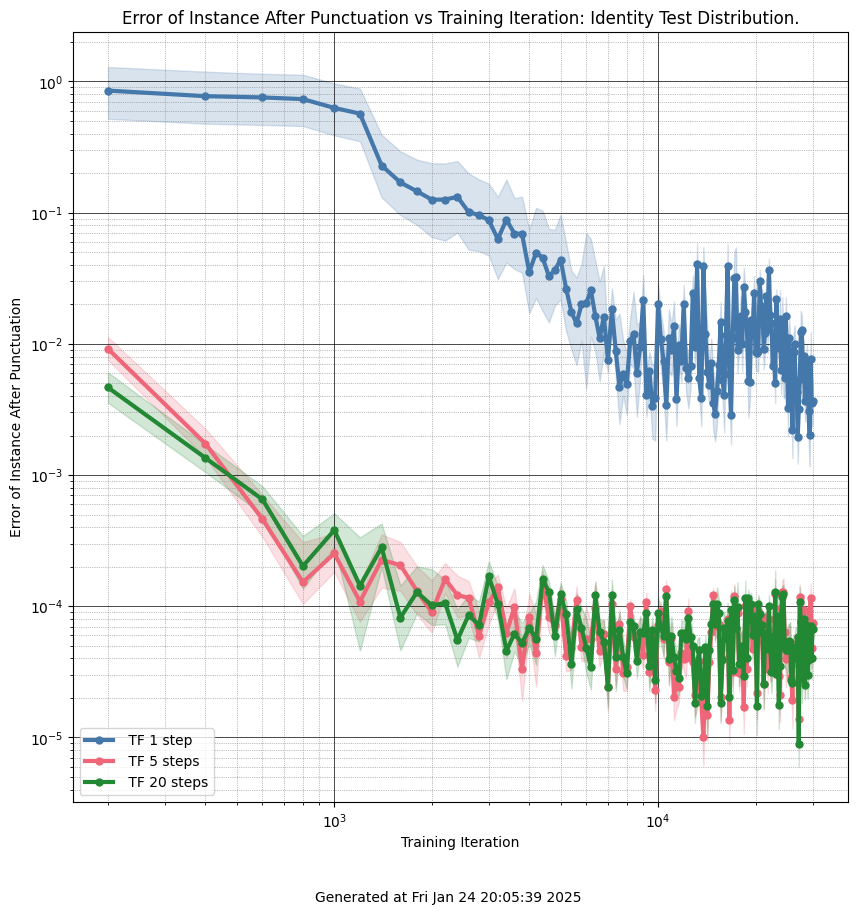

In [3]:
kal_ckpt = 81000
train_conv_plots([experiment], ["Identity"], [kal_ckpt], "ident", "_ident_C", 25, True, None, 100, 15000, 100, state_dim, single_system=True, nope=nope)